In [2]:
# Import all the dependencies and define some helpful functions
import numpy as np
import random
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import logging as log
from src.plotting import *
%load_ext autoreload
%autoreload 2

# set plotting style
%matplotlib inline
plt.style.reload_library()
plt.style.use('ucla_presentations')
mpl.rcParams['text.usetex'] = False

# configure logging
log.basicConfig(level= log.INFO, format = '')


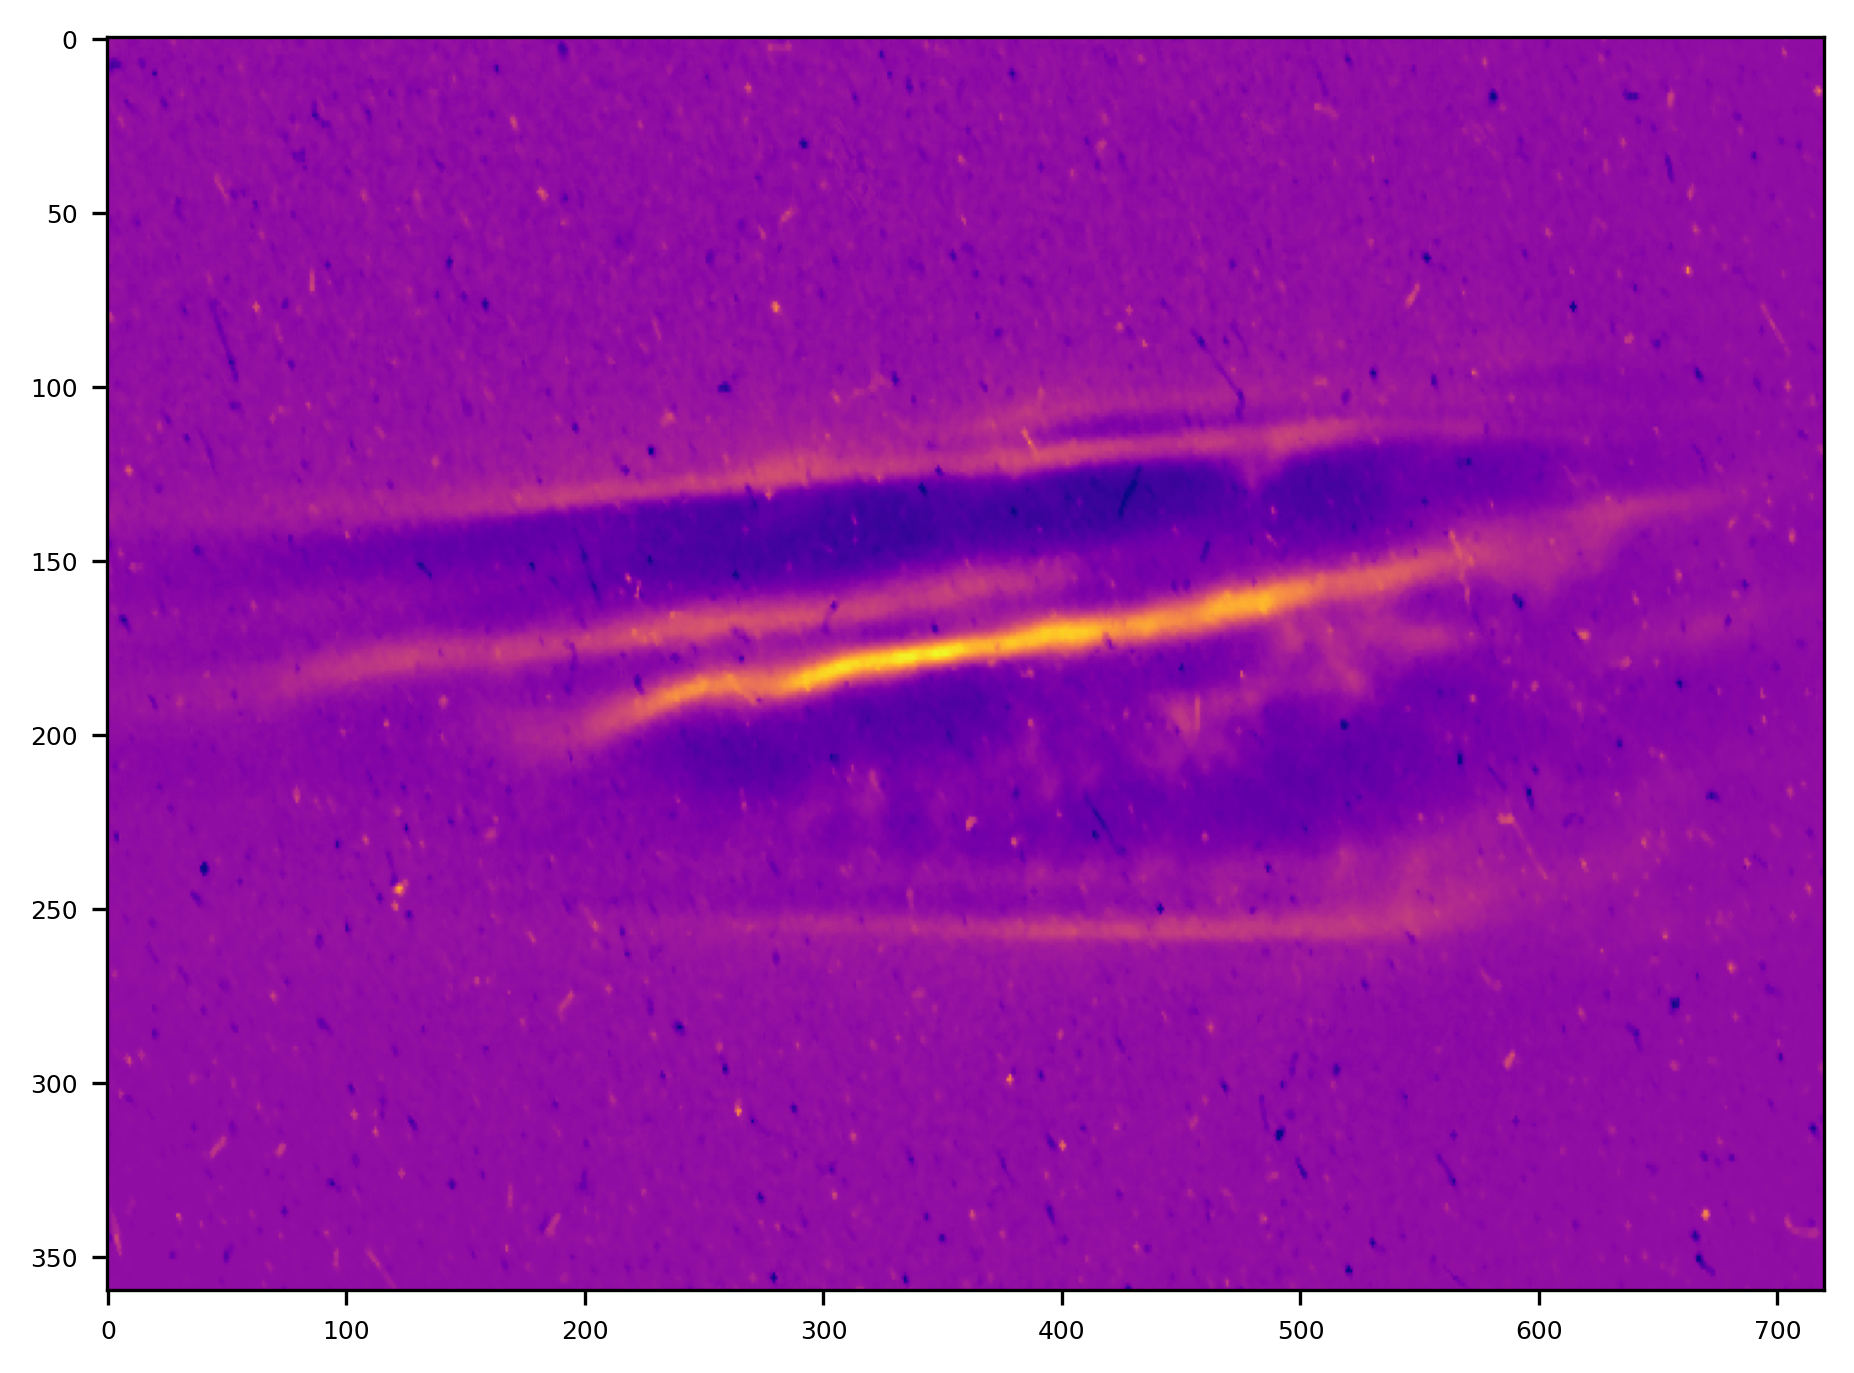

In [4]:
data_dir = '2022_data/'
fname = data_dir + '160psi-data-new/co2_27.4mJ_delayRail205mm_micro8.5mm_PMQs41mm_h2_164.2psig.png'
data = plt.imread(fname)

plt.imshow(data)

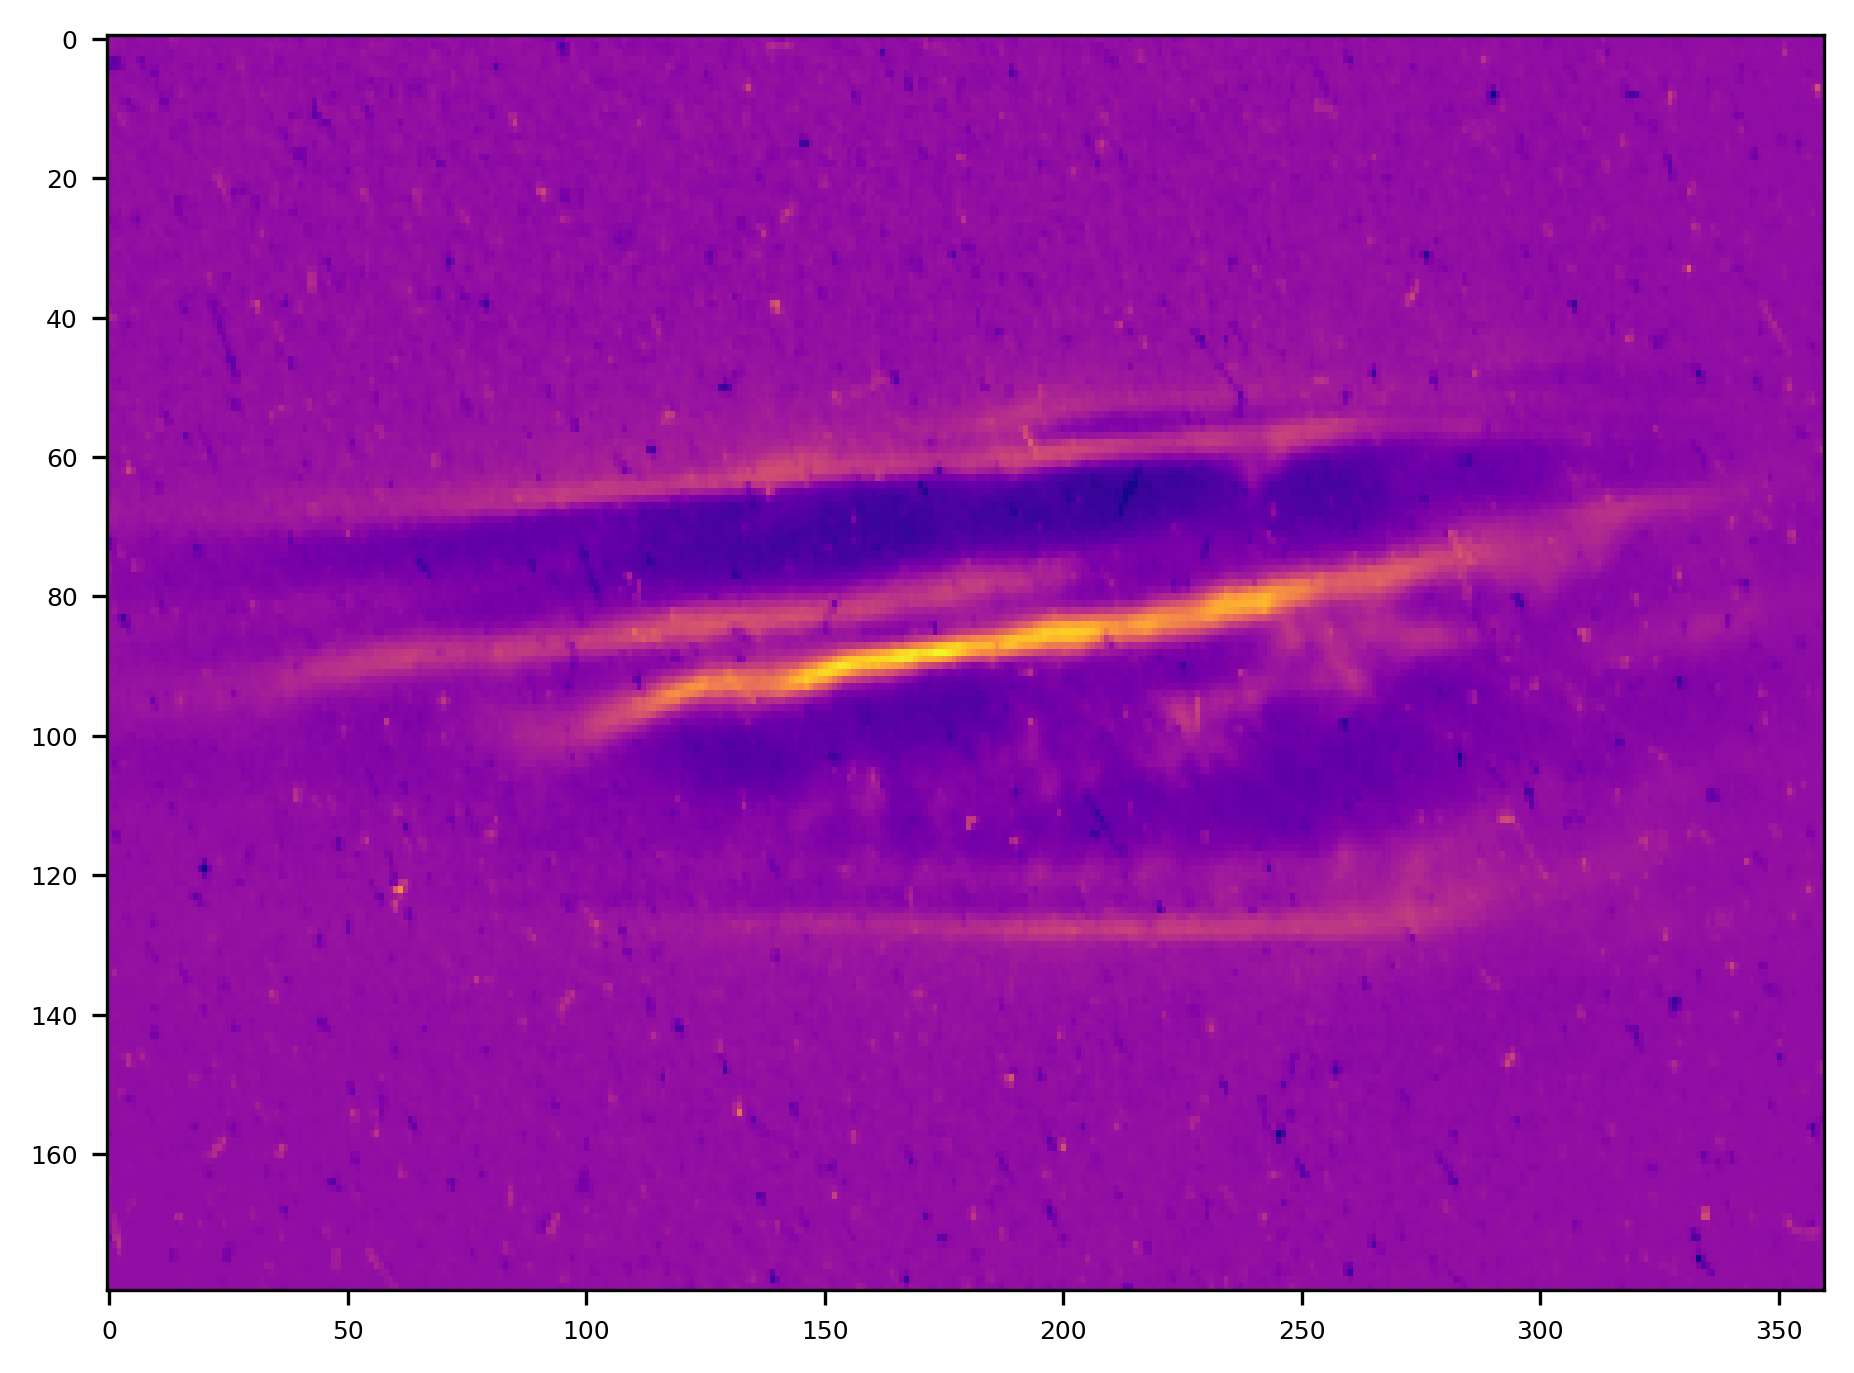

In [5]:
from skimage.measure import block_reduce
data = block_reduce(data, (2,2))
plt.imshow(data)

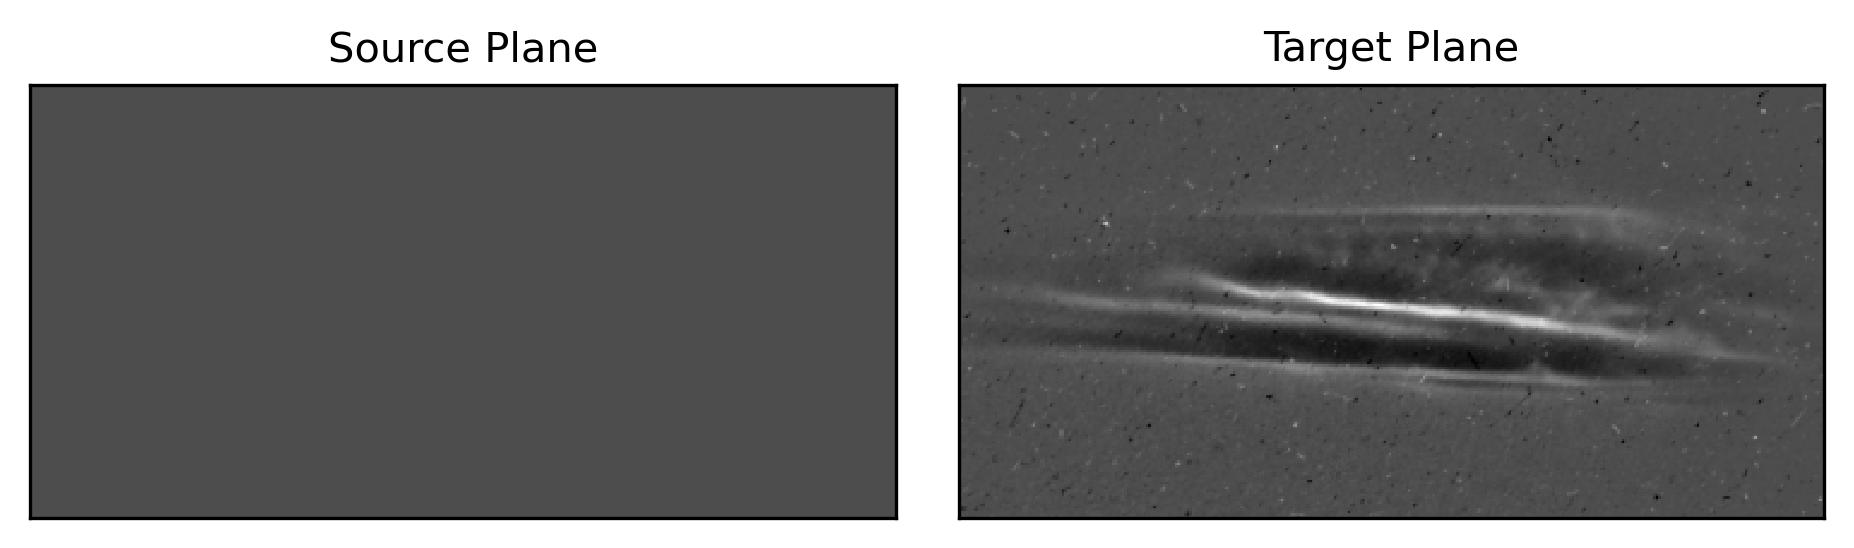

In [29]:
#from scipy.io import loadmat

# Load in the benchmark images from binary Matlab files

tar_img = np.array(data, dtype=np.float64)
src_img = np.ones_like(data)

# Normalize the images
shape = tar_img.shape
N_pix = shape[0] * shape[1]
tar_img *= N_pix / np.sum(tar_img)
src_img *= N_pix / np.sum(src_img)

fig, (ax1, ax2) = plt.subplots(1,2)
Y, X = np.indices(tar_img.shape)

ax1.pcolormesh(X,Y, src_img, cmap='gray', vmax=tar_img.max(), vmin = tar_img.min())
ax1.set_aspect('equal')
no_ticks(ax1)
ax1.set_title("Source Plane")

ax2.pcolormesh(X, Y, tar_img, cmap='gray', vmax=tar_img.max(), vmin = tar_img.min())
ax2.set_aspect('equal')
no_ticks(ax2)
ax2.set_title("Target Plane")
plt.show()

In [7]:
%%time
from src import optimal_transport as ot

N = int(.1 * N_pix)
source = ot.initialize_sites(src_img, N)

Deploying N = 6480 sites on the source plane...
Performing Lloyd relaxation on the source plane...
All centroids within 10.0% after 12 iterations of Lloyd relaxation


CPU times: user 20.2 s, sys: 52.5 s, total: 1min 12s
Wall time: 1min 16s


Optimizing cell weights on the target plane (this will take a while)...
nfev = 0, f = -110272.5
nfev = 5, f = -139050.7
nfev = 10, f = -165529.5
nfev = 15, f = -172579.1
nfev = 20, f = -175274.9
nfev = 25, f = -176215.1
nfev = 30, f = -176659.7
nfev = 35, f = -177012.8
nfev = 40, f = -177425.5
nfev = 45, f = -178015.3
nfev = 50, f = -178595.1
nfev = 55, f = -179243.5
nfev = 60, f = -180167.3
nfev = 65, f = -181095.0
nfev = 70, f = -181655.9
nfev = 75, f = -182062.4
nfev = 80, f = -182390.5
nfev = 85, f = -182686.0
nfev = 90, f = -183008.0
nfev = 95, f = -183312.4
nfev = 100, f = -183621.0
nfev = 105, f = -183843.5
nfev = 110, f = -183980.0
nfev = 115, f = -184068.9
nfev = 120, f = -184122.8
nfev = 125, f = -184166.4
nfev = 130, f = -184197.4
nfev = 135, f = -184220.4
nfev = 140, f = -184236.0
nfev = 145, f = -184250.7
nfev = 150, f = -184264.2
nfev = 155, f = -184272.4
nfev = 160, f = -184277.8
nfev = 165, f = -184281.8
nfev = 170, f = -184285.8
nfev = 175, f = -184289.8
nfev = 180, f 

CPU times: user 12min 39s, sys: 1h 20min 37s, total: 1h 33min 16s
Wall time: 1h 31min 47s


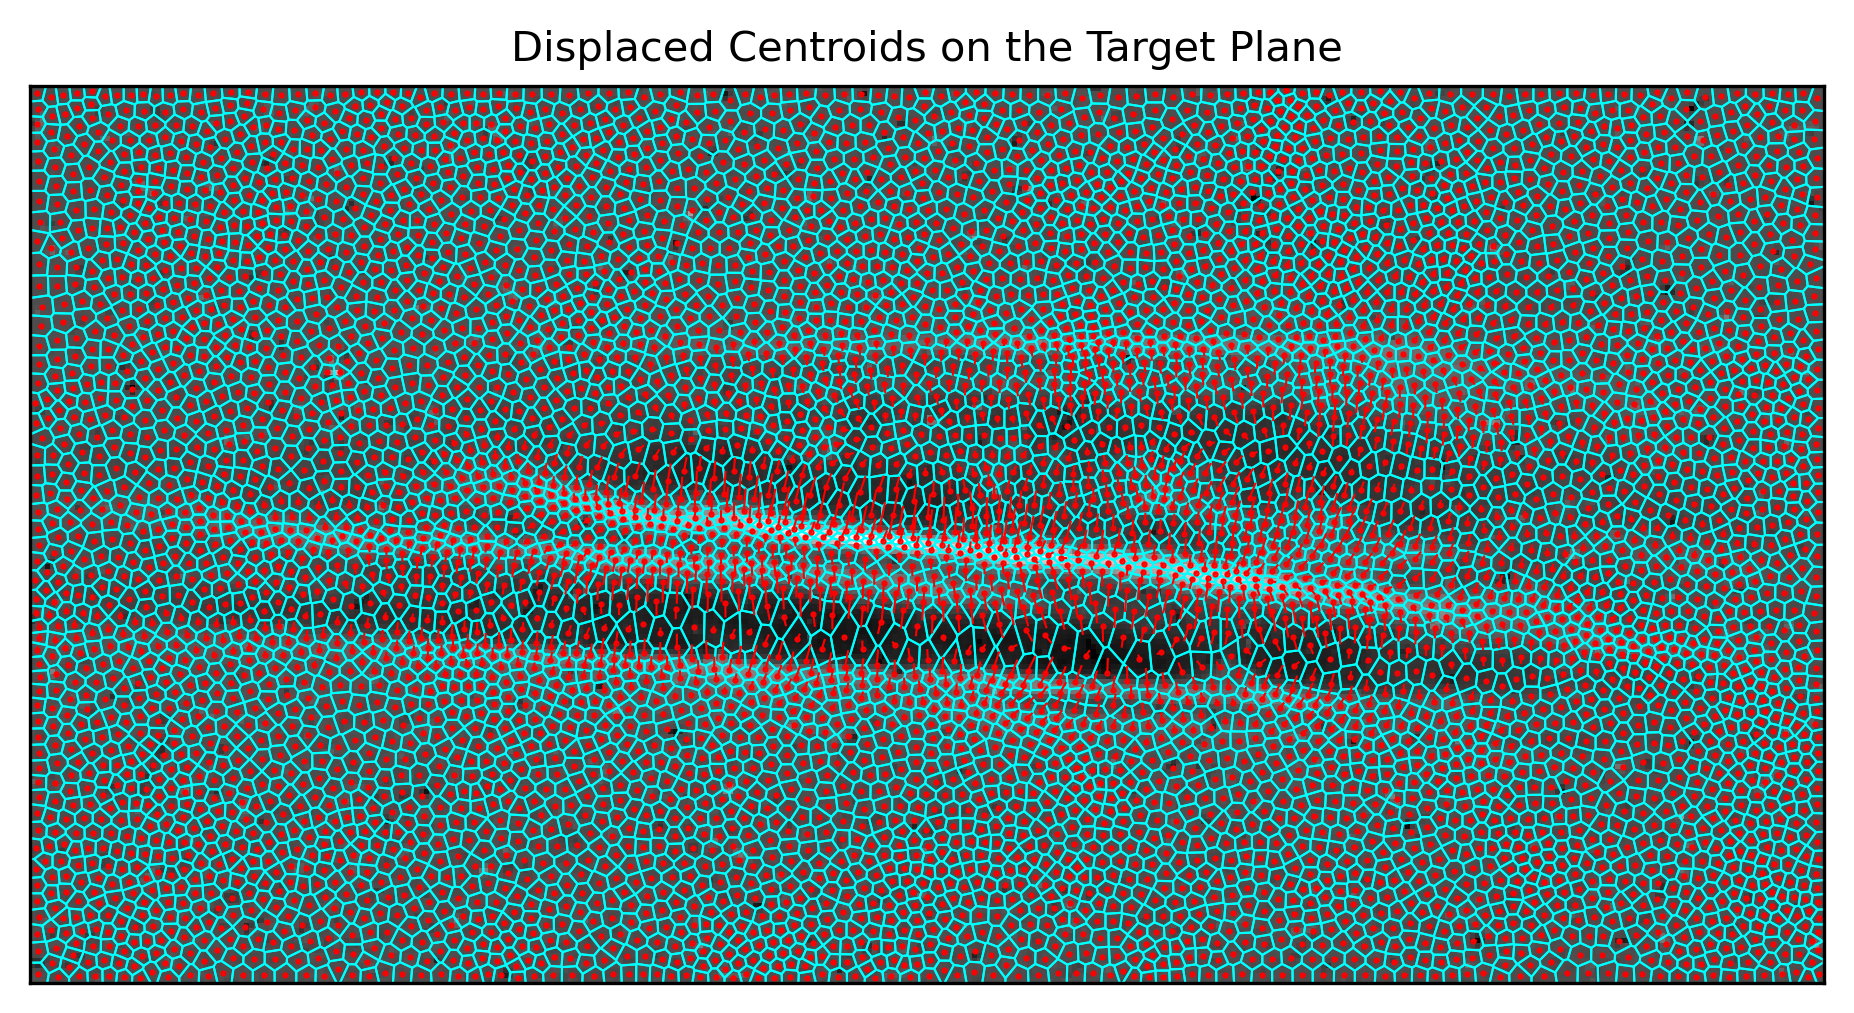

In [8]:
%%time
target, phi_c, a_x, a_y, result = ot.get_deflection_potential(tar_img, src_img, N, sites=source.sites)
ot.plot_displacements(target)

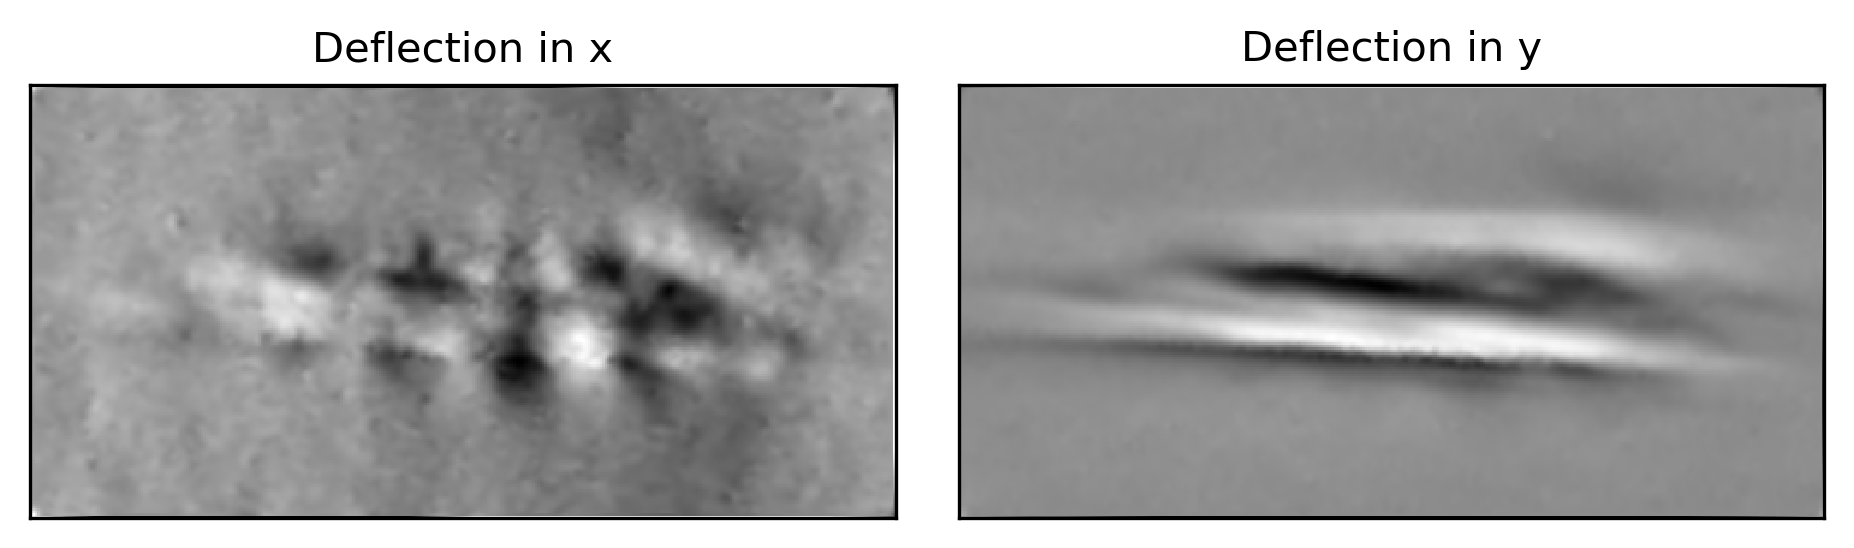

In [9]:
pad = 5

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.pcolormesh(X,Y, a_x, cmap='gray', vmax=a_x[pad:-pad, pad:-pad].max(), vmin = a_x[pad:-pad, pad:-pad].min())
ax1.set_aspect('equal')
no_ticks(ax1)
ax1.set_title("Deflection in x")

ax2.pcolormesh(X,Y, a_y, cmap='gray', vmax=a_y[pad:-pad, pad:-pad].max(), vmin = a_y[pad:-pad, pad:-pad].min())
ax2.set_aspect('equal')
no_ticks(ax2)
ax2.set_title("Deflection in y")
plt.show()

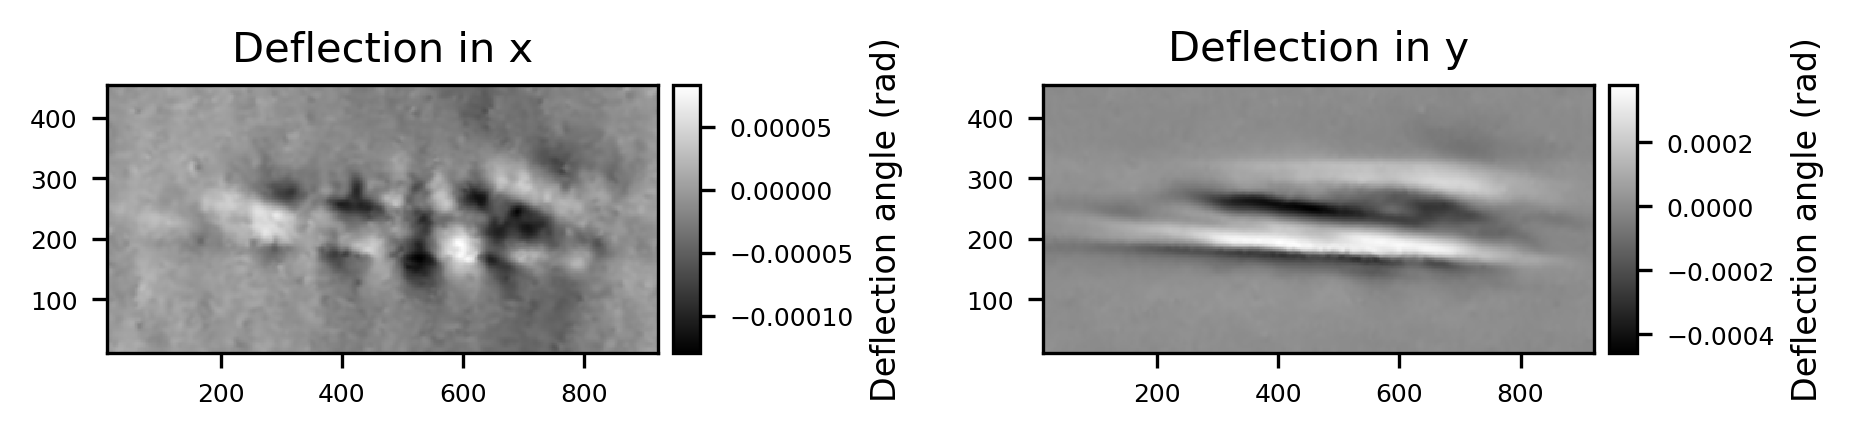

In [31]:
# Convert pixel displacement to deflection angle in radians
import astropy.units as u
from astropy.units import dimensionless_unscaled as dl
from astropy.constants import e, c, m_e, mu0
e = e.to(u.C)

pix_size = 1.3 * u.um # pixel size (magnification already included)
# (17.8 total, 4.8x optical magnification, 3.7x PMQ magnification)
tar_dist = 3   * u.cm # distance from IP to object plane of PMQs
M = 2 # magnification from downsampling the data

Y, X = np.indices(tar_img.shape, dtype=float) * (pix_size.value * M)

phi = phi_c / tar_dist * pix_size**2 * M

angle_x = a_x  * (pix_size * M / tar_dist).to_value(dl)
angle_y = a_y  * (pix_size * M / tar_dist).to_value(dl) 

fig, (ax1, ax2) = plt.subplots(1,2)

im1 = ax1.pcolormesh(X[pad:-pad, pad:-pad],Y[pad:-pad, pad:-pad], angle_x[pad:-pad, pad:-pad], cmap='gray',)
ax1.set_aspect('equal')
cbar1 = colorbar(im1)
cbar1.set_label('Deflection angle (rad)')
#no_ticks(ax1)
ax1.set_title("Deflection in x")

im2 = ax2.pcolormesh(X[pad:-pad, pad:-pad],Y[pad:-pad, pad:-pad], angle_y[pad:-pad, pad:-pad], cmap='gray',)
ax2.set_aspect('equal')
cbar2 = colorbar(im2)
cbar2.set_label('Deflection angle (rad)')

#no_ticks(ax2)
ax2.set_title("Deflection in y")
plt.show()

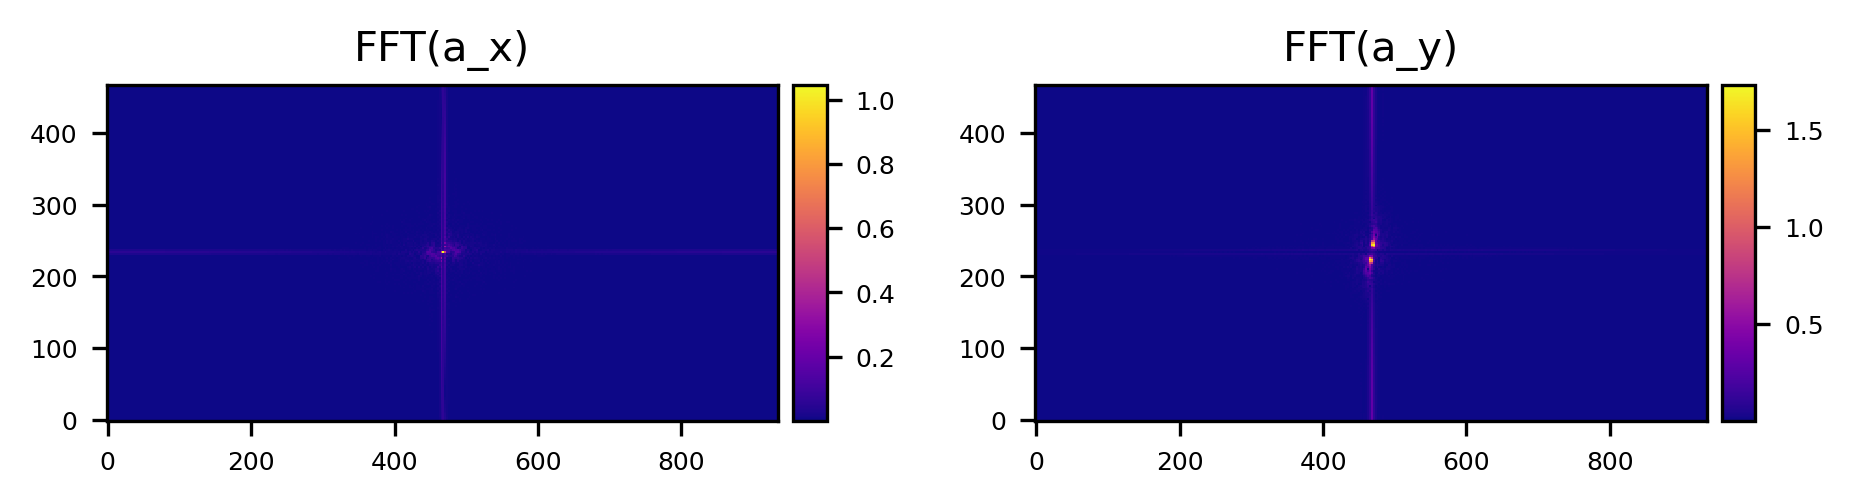

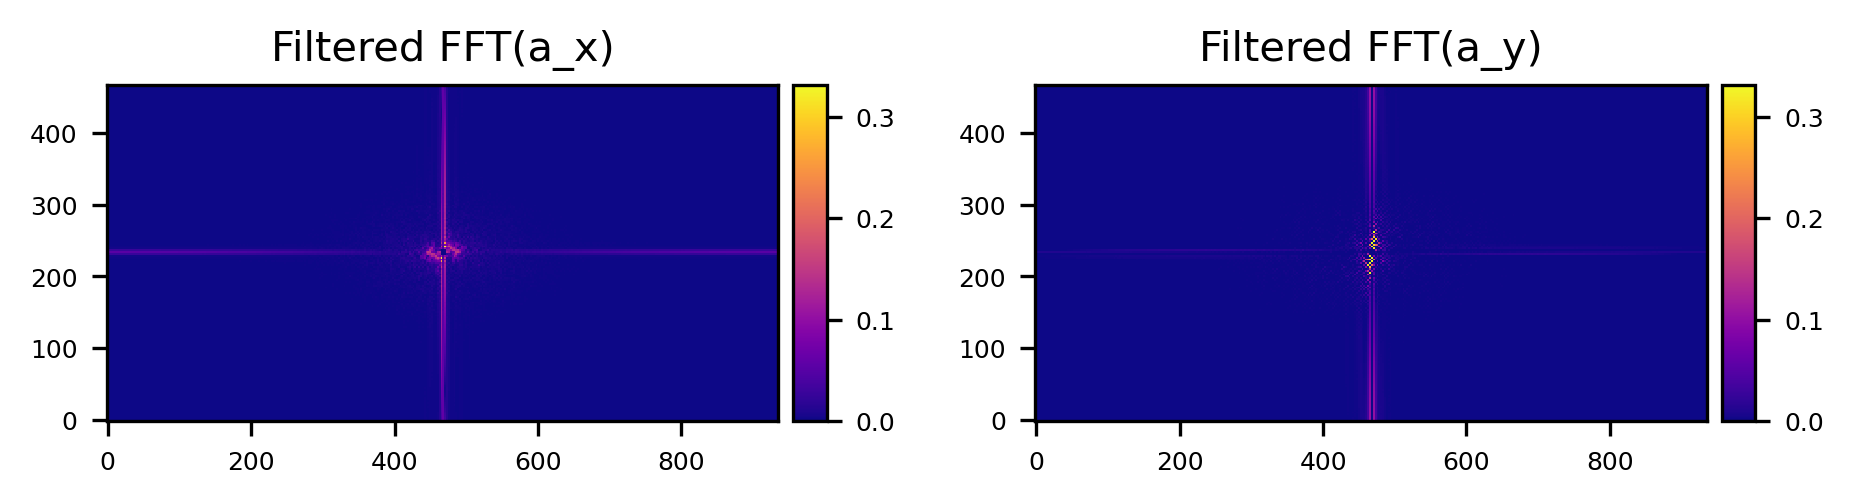

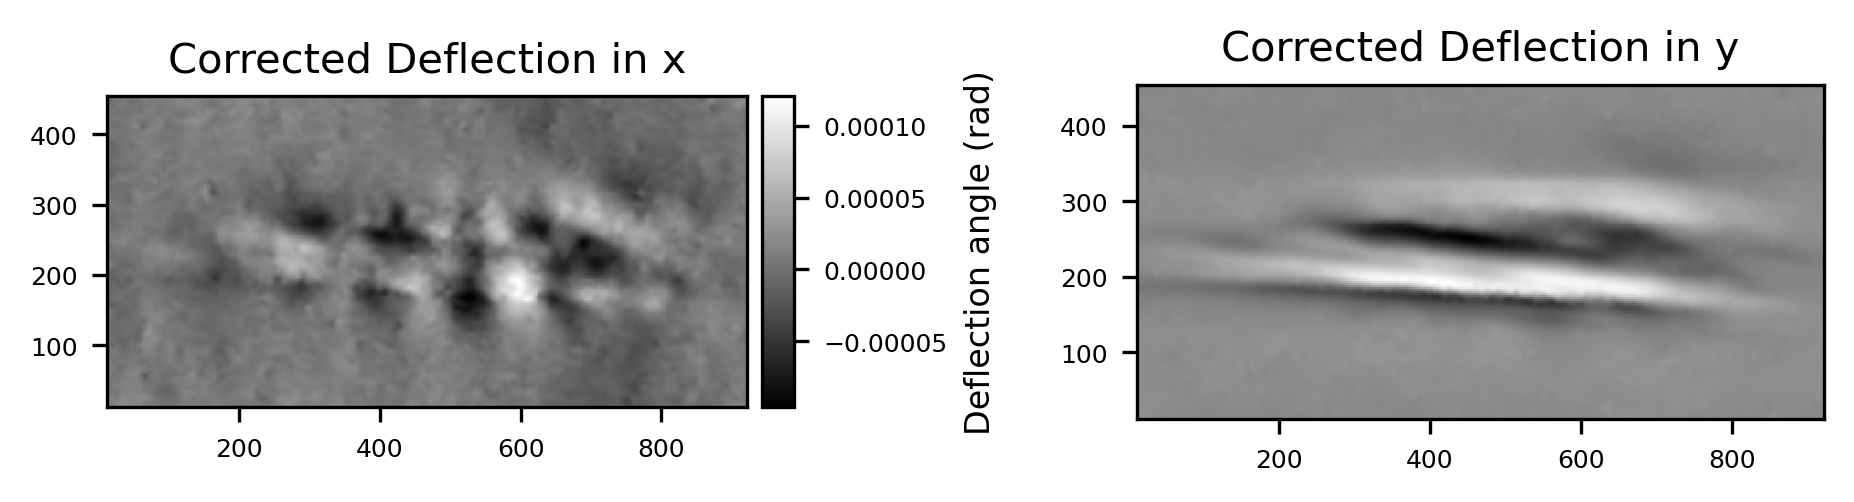

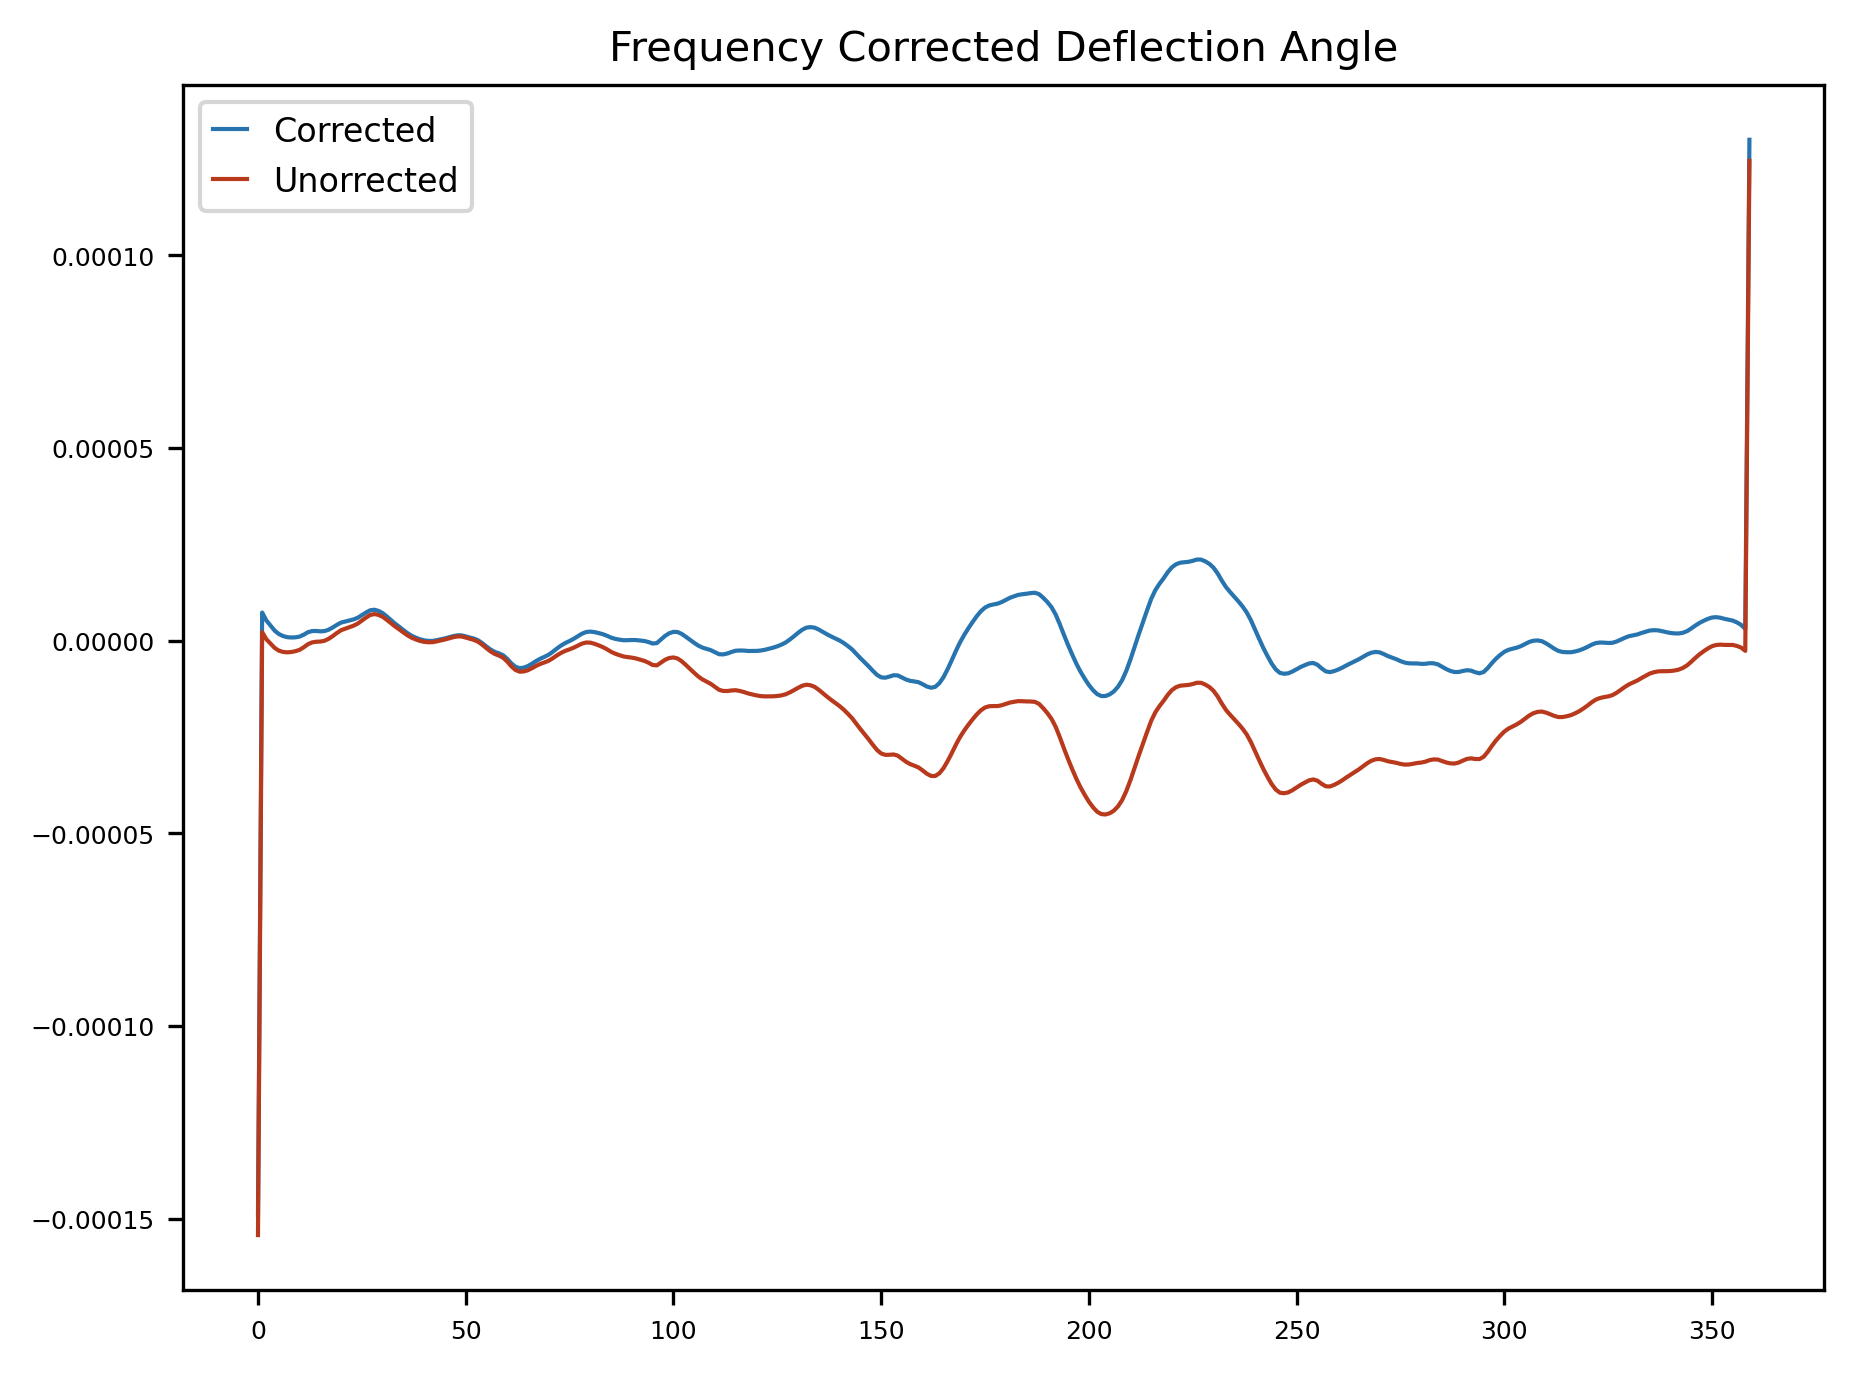

In [32]:
# Apply a high pass filter to correct for amplification of low frequencies

fftx = np.fft.fftshift(np.fft.fft2(angle_x))
ffty = np.fft.fftshift(np.fft.fft2(angle_y))
h, w = tar_img.shape

fig, (ax1, ax2) = plt.subplots(1,2)
im1 = ax1.pcolormesh(X,Y, np.abs(fftx), cmap='plasma')
ax1.set_aspect('equal')
cbar1 = colorbar(im1)
ax1.set_title("FFT(a_x)")

#im2 = ax2.pcolormesh(X,Y, ffty.real, cmap='plasma', vmax=fftx[pad:-pad, pad:-pad].real.max(), vmin = fftx[pad:-pad, pad:-pad].real.min())
im2 = ax2.pcolormesh(X,Y, np.abs(ffty), cmap='plasma')
ax2.set_aspect('equal')
cbar2 = colorbar(im2)

ax2.set_title("FFT(a_y)")
plt.show()

fftx[h//2 -1:h//2 +2, w//2 -1:w//2 +2] = 0
ffty[h//2 -1:h//2 +2, w//2 -1:w//2 +2] = 0
ax_corrected = np.fft.ifft2(np.fft.ifftshift(fftx)).real
ay_corrected = np.fft.ifft2(np.fft.ifftshift(ffty)).real

fig, (ax1, ax2) = plt.subplots(1,2)
im1 = ax1.pcolormesh(X,Y, np.abs(fftx), cmap='plasma')
ax1.set_aspect('equal')
cbar1 = colorbar(im1)
ax1.set_title("Filtered FFT(a_x)")

im2 = ax2.pcolormesh(X,Y, ffty.real, cmap='plasma', vmax=np.abs(fftx).max(), vmin = np.abs(fftx).min())
ax2.set_aspect('equal')
cbar2 = colorbar(im2)

ax2.set_title("Filtered FFT(a_y)")
plt.show()

fig, (ax1, ax2) = plt.subplots(1,2)

im1 = ax1.pcolormesh(X[pad:-pad, pad:-pad],Y[pad:-pad, pad:-pad], ax_corrected[pad:-pad, pad:-pad], cmap='gray', vmax=ax_corrected[pad:-pad, pad:-pad].max(),vmin=ax_corrected[pad:-pad, pad:-pad].min())
ax1.set_aspect('equal')
cbar1 = colorbar(im1)
cbar1.set_label('Deflection angle (rad)')
ax1.set_title("Corrected Deflection in x")

im2 = ax2.pcolormesh(X[pad:-pad, pad:-pad],Y[pad:-pad, pad:-pad], ay_corrected[pad:-pad, pad:-pad], cmap='gray', vmax=ay_corrected[pad:-pad, pad:-pad].max(), vmin=ay_corrected[pad:-pad, pad:-pad].min())
ax2.set_aspect('equal')
cbar2.set_label('Deflection angle (rad)')

ax2.set_title("Corrected Deflection in y")
plt.show()

fig, ax = plt.subplots()

ax.plot(np.mean(ax_corrected, axis=0), label='Corrected')
ax.plot(np.mean(angle_x, axis=0), label='Unorrected')
ax.legend()
ax.set_title("Frequency Corrected Deflection Angle")

plt.show()

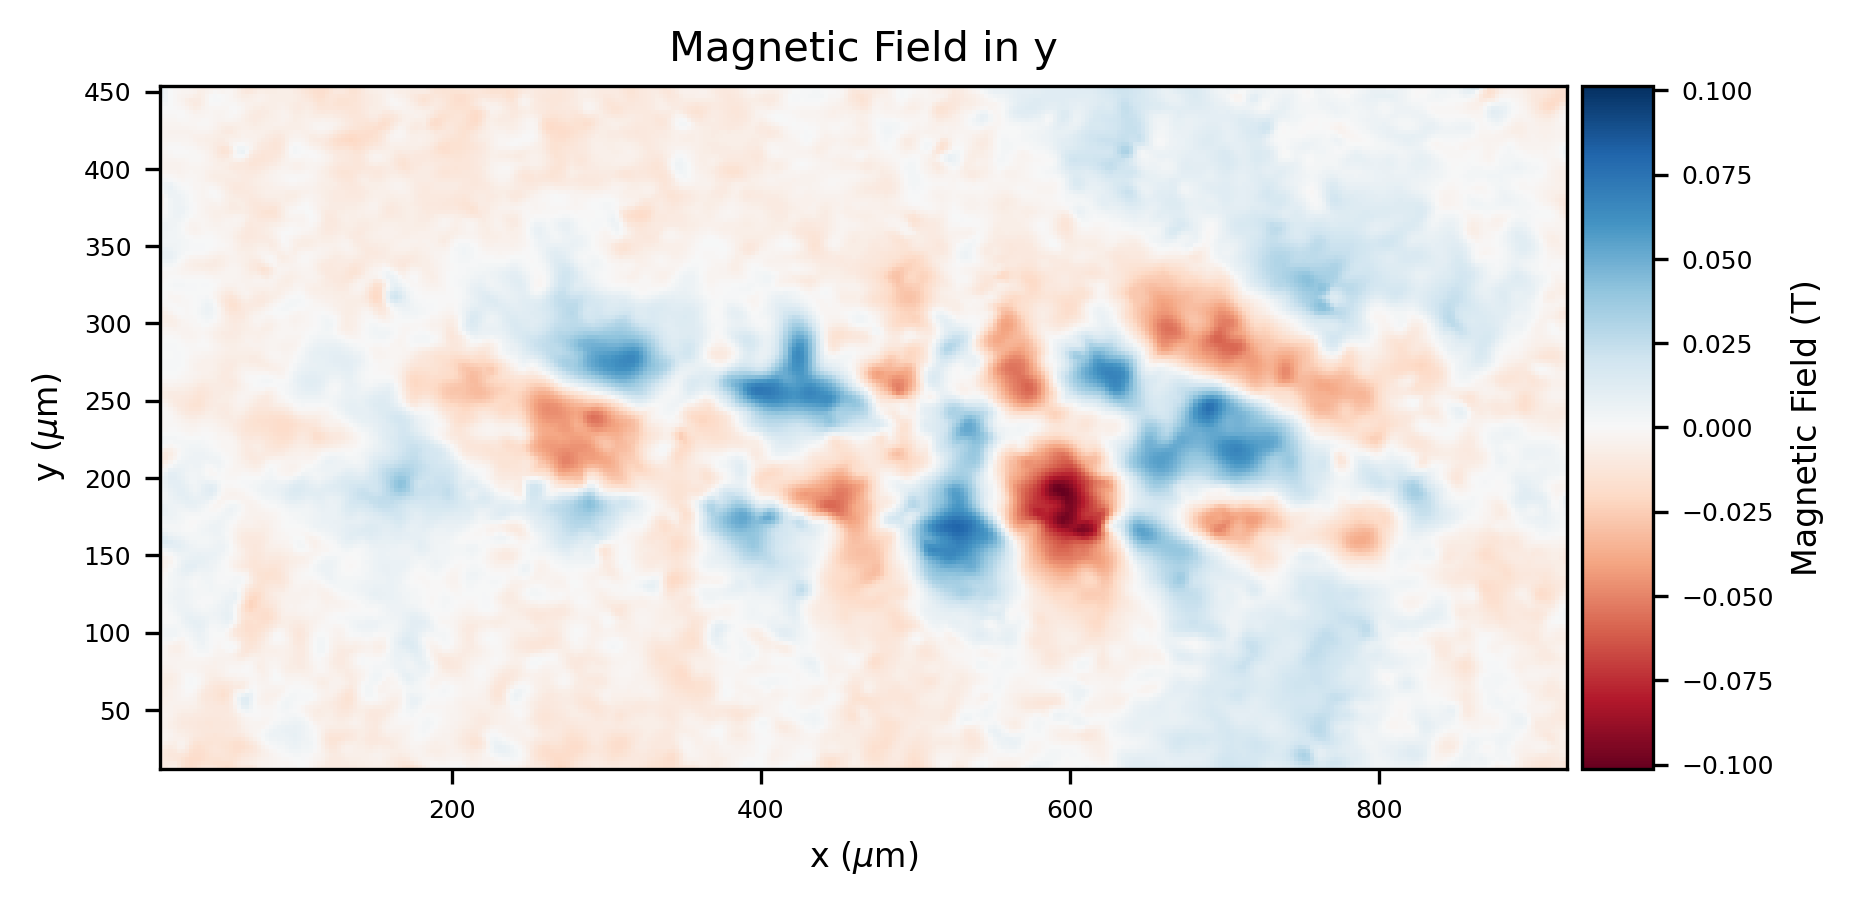

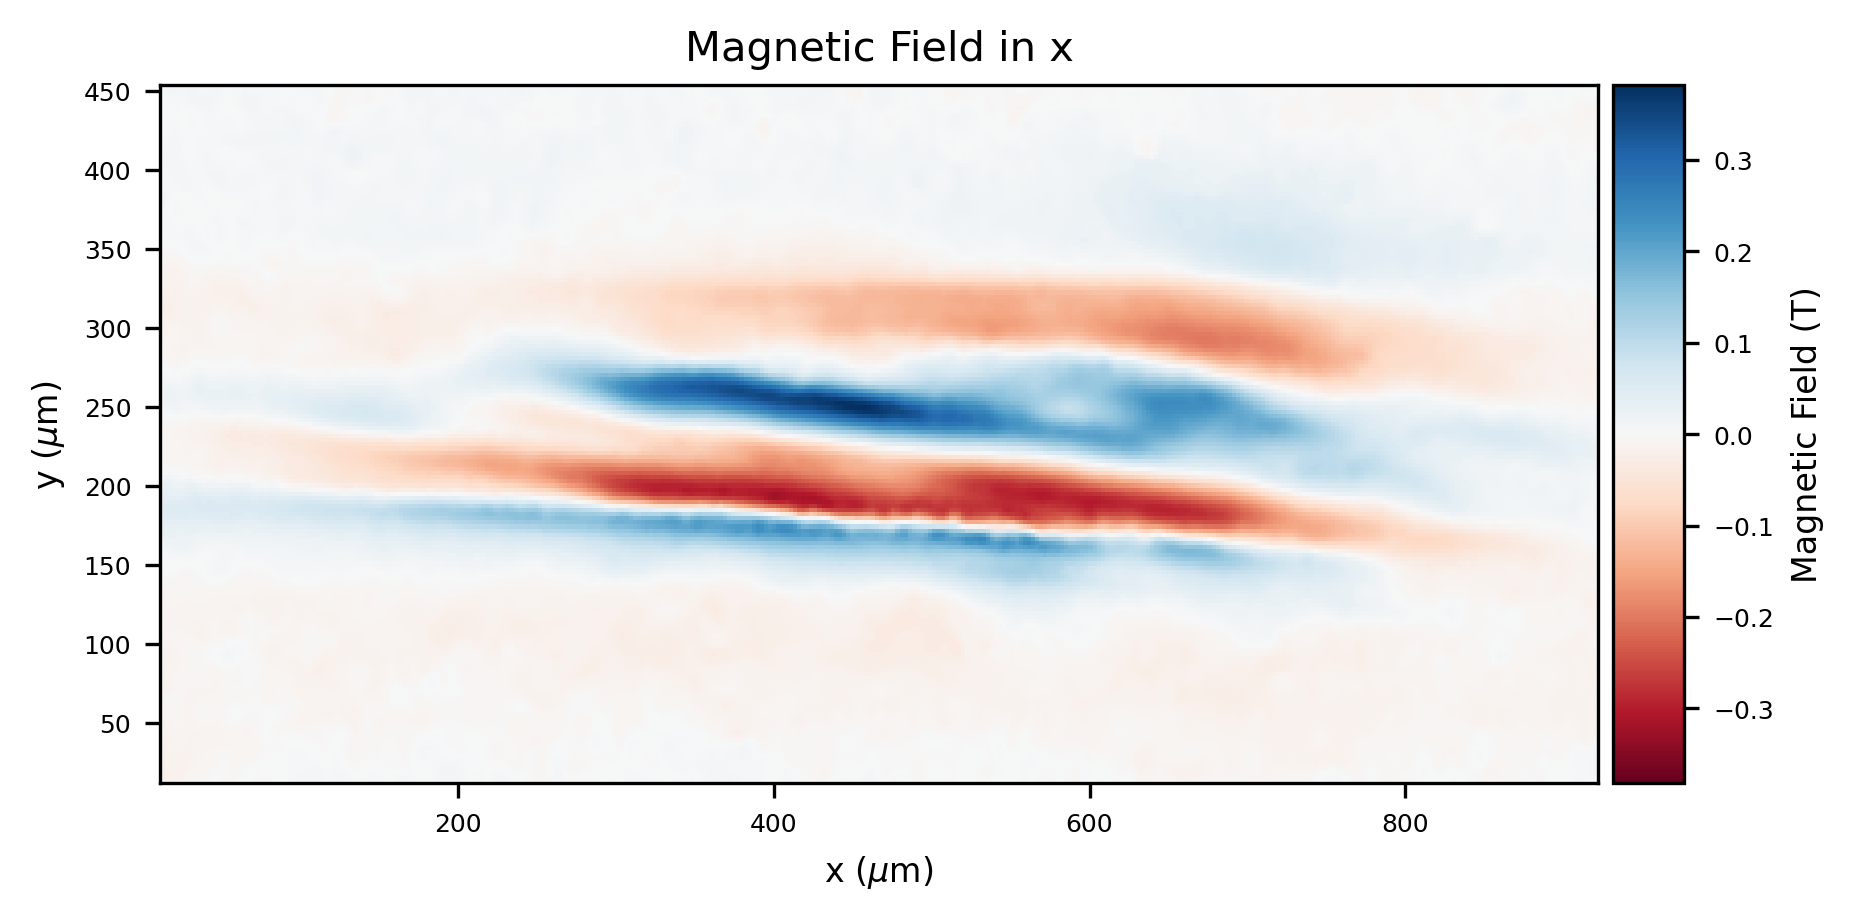

In [34]:
W = 200 * u.um
E = 50.5 * u.MeV

gamma = (E / (m_e * c**2)).to(u.dimensionless_unscaled)

By = (ax_corrected * np.sqrt(gamma**2 - 1) * m_e * c /  (-e * W)).to(u.T)
Bx = (ay_corrected * np.sqrt(gamma**2 - 1) * m_e * c /  (-e * W)).to(u.T)

fig, ax = plt.subplots()

im = ax.pcolormesh(X[pad:-pad, pad:-pad],Y[pad:-pad, pad:-pad], By[pad:-pad, pad:-pad], cmap='RdBu',vmax = max(By[pad:-pad, pad:-pad].max(), abs(By[pad:-pad, pad:-pad].min())).value, vmin = -1* max(By[pad:-pad, pad:-pad].max(), abs(By[pad:-pad, pad:-pad].min())).value)
ax.set_aspect('equal')
cbar = colorbar(im)
cbar.set_label('Magnetic Field (T)')
ax.set_xlabel('x ($\mu$m)')
ax.set_ylabel('y ($\mu$m)')
ax.set_title("Magnetic Field in y")

plt.show()

fig, ax = plt.subplots()

im = ax.pcolormesh(X[pad:-pad, pad:-pad],Y[pad:-pad, pad:-pad], Bx[pad:-pad, pad:-pad], cmap='RdBu', vmax = max(Bx[pad:-pad, pad:-pad].max(), abs(Bx[pad:-pad, pad:-pad].min())).value, vmin = -1* max(Bx[pad:-pad, pad:-pad].max(), abs(Bx[pad:-pad, pad:-pad].min())).value)
ax.set_aspect('equal')
cbar = colorbar(im)
cbar.set_label('Magnetic Field (T)')
ax.set_xlabel('x ($\mu$m)')
ax.set_ylabel('y ($\mu$m)')
ax.set_title("Magnetic Field in x")

plt.show()

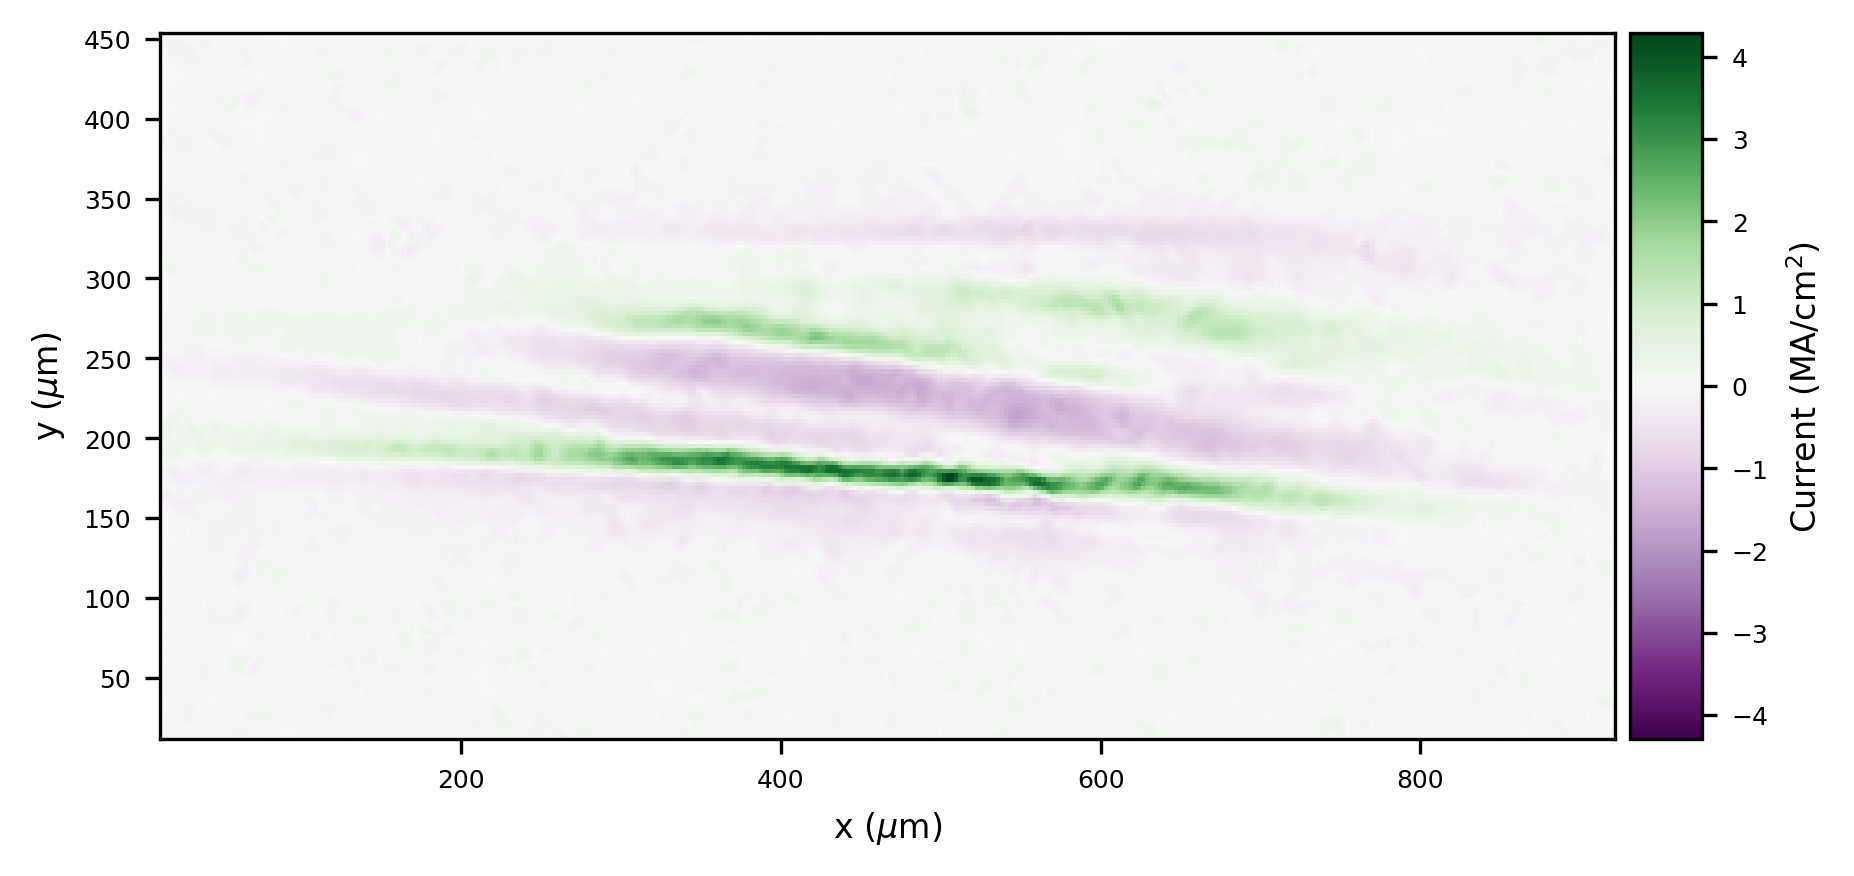

In [36]:
# Calculate the current from the fields in both directions
dBx = np.gradient(Bx, axis=0) / (pix_size * M)
dBy = np.gradient(By, axis=1) / (pix_size * M)
Jz = (1/mu0 * (dBy - dBx)).to(u.MA / u.cm**2)

fig, ax = plt.subplots()
im = ax.pcolormesh(X[pad:-pad, pad:-pad],Y[pad:-pad, pad:-pad], Jz[pad:-pad, pad:-pad], cmap='PRGn', vmax = max(Jz[pad:-pad, pad:-pad].max(), abs(Jz[pad:-pad, pad:-pad].min())).value, vmin = -1* max(Jz[pad:-pad, pad:-pad].max(), abs(Jz[pad:-pad, pad:-pad].min())).value)
cbar = colorbar(im)
cbar.set_label('Current (MA/cm$^2$)')
ax.set_aspect('equal')
ax.set_xlabel('x ($\mu$m)')
ax.set_ylabel('y ($\mu$m)')
plt.show()

In [15]:
np.savez(data_dir+'results.npz',
        source_image = src_img,
        target_image = tar_img,
        sites = target.sites,
        weights = target.weights,
        centroids = target.c,
        phi = phi_c,
        ax = a_x,
        ay = a_y)

In [16]:
from src import voronoi
res = np.load(data_dir+'results.npz',)

vor = voronoi.Voronoi(res['sites'],weights=res['weights'], shape=shape, image=res['target_image'])

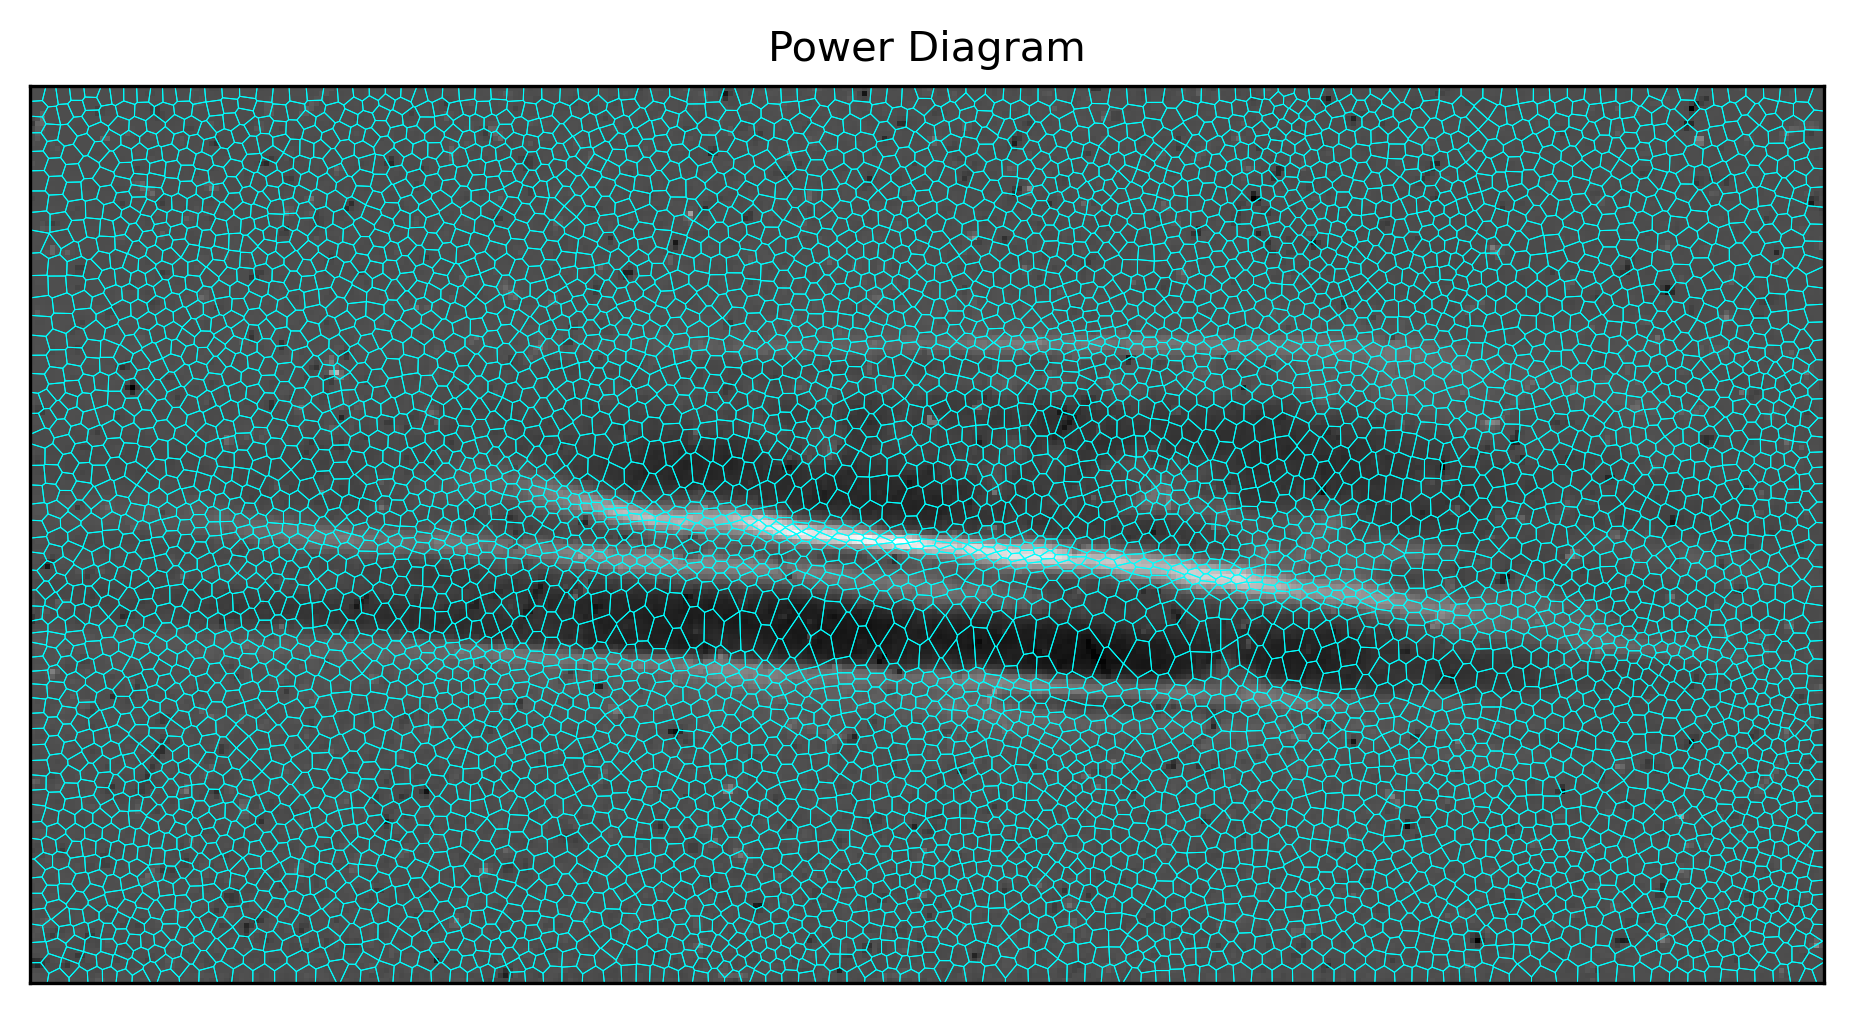

In [17]:
fig, ax = plt.subplots()

vor.plot(ax=ax, sites=False, plot_image = True,  lw=.25)
plt.show()